# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
# Put all of the helper functions in utils
import importlib
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload

In [2]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [2]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [5]:
encounters=df.groupby('encounter_id').count().patient_nbr.sort_values(ascending=False)
encounters

encounter_id
60016020     6
63184686     6
58316058     6
110310714    6
63415968     6
            ..
170219592    1
170232828    1
170264592    1
170265714    1
152388294    1
Name: patient_nbr, Length: 101766, dtype: int64

In [6]:
df.loc[df.encounter_id==encounters.index[0]][['patient_nbr', 'ndc_code']]

,patient_nbr,ndc_code
20816,2431710,0087-6063
20817,2431710,60429-435
20818,2431710,0591-0460
20819,2431710,0173-0861
20820,2431710,23155-148
20821,2431710,68071-1701


In [7]:
patients = df.groupby('patient_nbr').count().encounter_id.sort_values(ascending=False)
patients

patient_nbr
90609804    52
89472402    50
91751121    50
62352252    46
84397842    41
            ..
60064425     1
60064344     1
60063633     1
60063048     1
48164949     1
Name: encounter_id, Length: 71518, dtype: int64

In [8]:
df.loc[df.patient_nbr == patients.index[20]][['encounter_id', 'discharge_disposition_id']].head

<bound method NDFrame.head of         encounter_id  discharge_disposition_id
55963      127135518                         1
57912      130655706                         1
57913      130655706                         1
57914      130655706                         1
63815      143374980                         1
63816      143374980                         1
63817      143374980                         1
70662      153498534                         1
70663      153498534                         1
70664      153498534                         1
76186      160052880                         1
76187      160052880                         1
76188      160052880                         1
95162      192672246                        22
95163      192672246                        22
97796      200426748                         6
97797      200426748                         6
100487     209323626                         1
100488     209323626                         1
100489     209323626          

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

There are multiple encounter for a single patient are there are several lines with different medication for a single encounter of a single patient. So the dataset is at the line level.

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


In [4]:
data = pd.read_csv('../data_schema_references/project_data_schema.csv')
data.loc[data.Type=='numerical','Feature Name\n'].values

array(['weight', 'time_in_hospital', 'number_inpatient',
       'number_emergency', 'num_lab_procedures', 'number_diagnoses',
       'num_medications', 'num_procedures'], dtype=object)

In [3]:
numericals = ['time_in_hospital', 'number_outpatient','number_inpatient', 'number_emergency',
 'num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']

In [76]:
df.change.sort_values().unique()

array(['Ch', 'No'], dtype=object)

In [136]:
types=[]
tot = df.shape[0]
for i in df.columns:
    miss1 = df.loc[df[i].isna()].shape[0]
    miss2=0
    if type(df[i].values[0])==str:
        miss2 = df.loc[df[i].isin(['?', '?|?', 'None','Unknown/Invalid'])].shape[0]
    types.append([i, type(df[i].values[0]), df[i].dtype, (miss1+miss2)/tot])
tmp = pd.DataFrame(types)
tmp.columns=['feature','dtype','type','missing_ratio']
tmp

,feature,dtype,type,missing_ratio
0,encounter_id,<class 'numpy.int64'>,int64,0.000000
1,patient_nbr,<class 'numpy.int64'>,int64,0.000000
2,race,<class 'str'>,object,0.023071
3,gender,<class 'str'>,object,0.000035
4,age,<class 'str'>,object,0.000000
5,weight,<class 'str'>,object,0.970005
6,admission_type_id,<class 'numpy.int64'>,int64,0.000000
7,discharge_disposition_id,<class 'numpy.int64'>,int64,0.000000
8,admission_source_id,<class 'numpy.int64'>,int64,0.000000
9,time_in_hospital,<class 'numpy.int64'>,int64,0.000000


In [87]:
df.loc[(df.ndc_code.isna()) & (df.num_medications>0)].shape[0]/tot

0.16358489513609994

In [88]:
df.loc[(df.max_glu_serum =='None') & (df.num_lab_procedures>0)].shape

(136409, 26)

In [91]:
tmp = df.groupby('encounter_id').max_glu_serum.apply(list)
tmp

encounter_id
12522              [None, None]
15738              [None, None]
16680              [None, None]
28236                    [None]
35754                    [None]
                    ...        
443847548          [None, None]
443847782                [None]
443854148          [None, None]
443857166    [None, None, None]
443867222                [None]
Name: max_glu_serum, Length: 101766, dtype: object

time_in_hospital
number_outpatient
number_inpatient
number_emergency
num_lab_procedures
number_diagnoses
num_medications
num_procedures


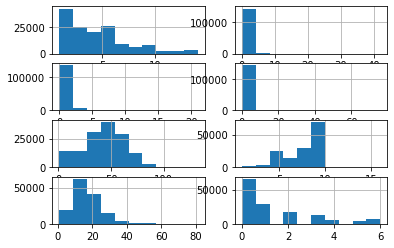

In [111]:
for idx, i in enumerate(numericals):
    print(i)
    plt.subplot(4,2,idx+1)
    df[i].hist()

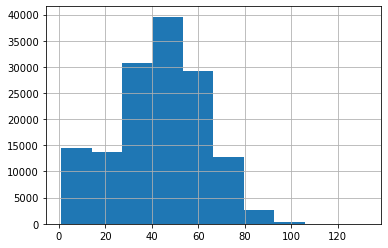

In [121]:
df.num_lab_procedures.hist();

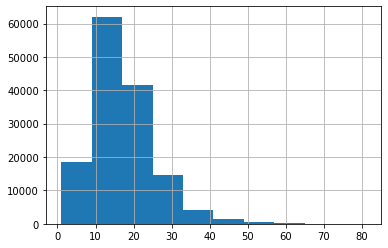

In [122]:
df.num_medications.hist();

**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 


In [5]:
!pip install tensorflow-data-validation

     |████████████████████████████████| 1.3 MB 586 kB/s eta 0:00:01
     |████████████████████████████████| 127 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 8.7 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 650 kB/s eta 0:00:01
     |████████████████████████████████| 151 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.0 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 829 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 173 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 187 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 92 kB 702 kB/s eta 0:00:01
     |████████████████████████████████| 267 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 67 kB 543 kB/s eta 0:00:01
     |████████████████████████████████| 134 kB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 169 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 225 k

     |████████████████████████████████| 505 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 338 kB/s eta 0:00:01
     |████████████████████████████████| 98 kB 625 kB/s eta 0:00:01
     |████████████████████████████████| 106 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 44 kB 317 kB/s eta 0:00:01
     |████████████████████████████████| 63.8 MB 81 kB/s  eta 0:00:01
     |████████████████████████████████| 512 kB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 320.4 MB 8.0 kB/s eta 0:00:01    |██                              | 20.1 MB 700 kB/s eta 0:07:09     |███▎                            | 33.3 MB 1.2 MB/s eta 0:03:56     |██████████████████████████▌     | 264.9 MB 1.4 MB/s eta 0:00:40     |██████████████████████████▉     | 269.1 MB 1.1 MB/s eta 0:00:46     |██████████████████████████████▎ | 302.8 MB 1.1 MB/s eta 0:00:16
     |████████████████████████████████| 20.1 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 459 k

     |████████████████████████████████| 61 kB 4.6 kB/s eta 0:00:01
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=0e8d397d6d870433a8134106f44eb014912cacef082708367aab18e0154a7851
  Stored in directory: /home/francois/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for crcmod: filename=crcmod-1.7-cp37-cp37m-linux_x86_64.whl size=36527 sha256=5f4963cad46ff681c7d97c0b40aaa30a69cd35ebb4c9422106f08297b1240d3d
  Stored in directory: /home/francois/.cache/pip/wheels/dc/9a/e9/49e627353476cec8484343c4ab656f1e0d783ee77b9dde2d1f
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78532 sha256=32f897f4efe4386f6e227213f8624e237142411c449fbfc2f74e868b66b832f7
  Stored in directory: /home/francois/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=24c74050bcbf7aa7b79168b83d1

In [6]:
######NOTE: The visualization will only display in Chrome browser. ########
import tensorflow_data_validation as tfdv
full_data_stats = tfdv.generate_statistics_from_csv(data_location=dataset_path) 
tfdv.visualize_statistics(full_data_stats)
#doesn't work for me. Moreover tensorflow-data-validation is not compatible with tensorflow 2.4 whish is required for tensorflow-probability.

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [7]:
from scipy import stats
print(stats.shapiro(df.sample(1000).num_lab_procedures.values))
print(stats.shapiro(df.sample(1000).num_medications.values))

ShapiroResult(statistic=0.9827405214309692, pvalue=1.6873188402044548e-09)
ShapiroResult(statistic=0.8969937562942505, pvalue=2.416772511643525e-25)


In [129]:
cardinals=[]
for i in set(df.columns)-set(numericals):
    cardinals.append([i, len(df[i].unique())])
tmp = pd.DataFrame(cardinals)
tmp.columns = ['feature', 'cardinality']
tmp.sort_values('cardinality', ascending=False)

,feature,cardinality
15,encounter_id,101766
8,patient_nbr,71518
1,other_diagnosis_codes,19374
0,primary_diagnosis_code,717
17,ndc_code,252
11,medical_specialty,73
5,discharge_disposition_id,26
13,payer_code,18
2,admission_source_id,17
10,age,10


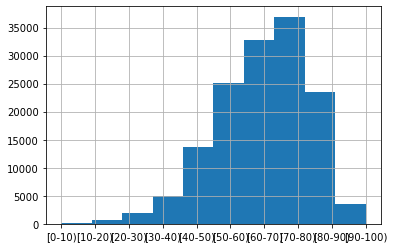

In [132]:
df.age.hist();

In [138]:
df.age.describe()

count      143424
unique         10
top       [70-80)
freq        36928
Name: age, dtype: object

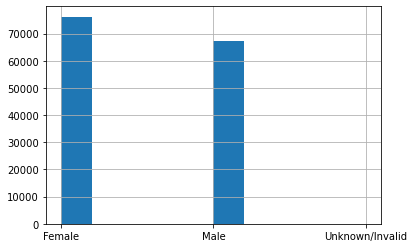

In [134]:
df.gender.hist();

In [137]:
df.loc[df.gender=='Female'].shape[0]/df.loc[df.gender=='Male'].shape[0]

1.1331320462861052

a) Medical_specialty, payer_code and ndc_code are missing in more than 15% of the cases. 
However ndc_codes should be mentionned if it is a line of medication and checking missing ndc_code for lines where num_medication is >0 return the same results so ndc_code are trully missing.
Moreover max_glu_serum and A1Cresult are not available in more than 80% of the lines. Exploring missing values for max_glu_serum for an encounter returns also missing values for all lines of the encounter.

b) From numerical values only num_lab_procedures and num_medications are close to normal.

c) other_diagnosis_codes, primary_diagnosis_code and ndc_code have hight cardinality and could be embedded. On the other side, patient_nbr, encounter_id and encounter are quasi-unique identifier and should not be used as features.

d) The female/male ratio is equal to 1.13. Ages distribution is increasing until 70-80 years (the top of fraquencies of distribution) and drop until 100 years.

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [3]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [4]:
from student_utils import reduce_dimension_ndc
reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [5]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()
print("Tests passed!!")

Tests passed!!


## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [6]:
from student_utils import select_first_encounter
first_encounter_df = select_first_encounter(reduce_dim_df)

In [7]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:56133
Number of unique encounters:56133
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [8]:
exclusion_list = ['generic_drug_name', 'ndc_code', 'NDC_Code']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/francois/Documents/dataMutation/udacity/nd320-c1-emr-data-starter/project/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [9]:
assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

Student response: 
- weight is excluded beacause there are too much missing values.
- payer_code contains also a lot of missing values. Moreover this feature may not be related to health condition.

In [15]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
crossed_age_gender_feature = tf.feature_column.crossed_column(['age','gender'], hash_bucket_size=1000)
ageXgender_feature = tf.feature_column.indicator_column(crossed_age_gender_feature)
student_categorical_col_list = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty','primary_diagnosis_code',
                                'other_diagnosis_codes', 'max_glu_serum', 'A1Cresult', 'change'] + required_demo_col_list + ndc_col_list


student_numerical_col_list = ['num_procedures', 'num_medications', 'number_diagnoses']
#student_numerical_col_list  ['time_in_hospital', 'number_outpatient','number_inpatient', 'number_emergency','num_lab_procedures', 'number_diagnoses', 'num_medications', 'num_procedures']
PREDICTOR_FIELD = 'time_in_hospital'#readmitted'

In [16]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr', ageXgender_feature):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list 
    return agg_drug_df[selected_col_list]


In [17]:
selected_features_df = select_model_features(agg_drug_df, student_categorical_col_list, student_numerical_col_list,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

<AxesSubplot:>

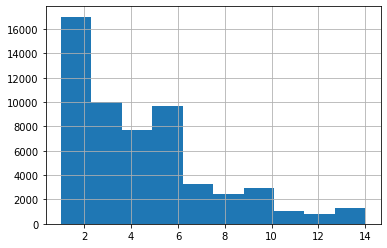

In [96]:
selected_features_df[PREDICTOR_FIELD].hist()

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [18]:
#map_target = dict({'NO':0, '>30':1, '<30':2})
#selected_features_df[PREDICTOR_FIELD] = selected_features_df[PREDICTOR_FIELD].apply(lambda x: map_target[x])
# add ageXgender_feature here
processed_df = preprocess_df(selected_features_df, student_categorical_col_list, 
        student_numerical_col_list, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/francois/Documents/dataMutation/udacity/nd320-c1-emr-data-starter/project/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/francois/Documents/dataMutation/udacity/nd320-c1-emr-data-starter/project/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/francois/Documents/dataMutation/udacity/nd320-c1-emr-data-starter/project/starter_code/utils.py:33: SettingWithCopyWarning:

## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [36]:
#Since aggregate_dataset process, there only one line per patient thus there is no leakage possible by sharing patient data across samples
processed_df.groupby('patient_nbr')[['readmitted']].count().readmitted.unique()

array([1])

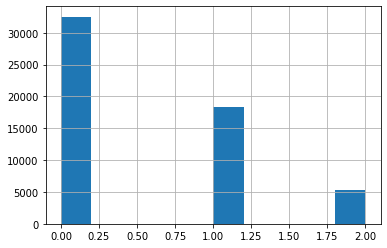

In [37]:
processed_df.readmitted.hist();
# if we want Total number of rows in original dataset = sum of rows across all three dataset partitions. There is no room to make balanced dataset for the predictor

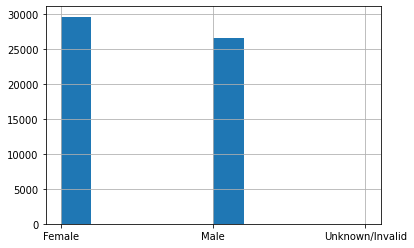

In [41]:
processed_df.gender.hist();

In [43]:
processed_df.age.unique()

array(['[80-90)', '[90-100)', '[40-50)', '[50-60)', '[60-70)', '[70-80)',
       '[20-30)', '[10-20)', '[30-40)', '[0-10)'], dtype=object)

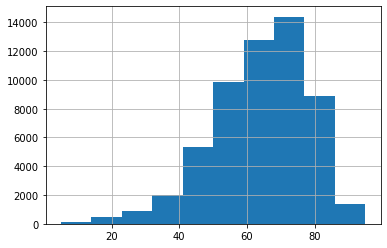

In [60]:
processed_df['age_num'] = [(int(j[0])+int(j[1]))/2 for j in [i[1:-1].split('-') for i in processed_df.age.values]]
processed_df.age_num.hist();

In [19]:
import student_utils
from student_utils import patient_dataset_splitter
d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

In [20]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [21]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

readmitted
0.0    32525
1.0    18328
2.0     5280
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


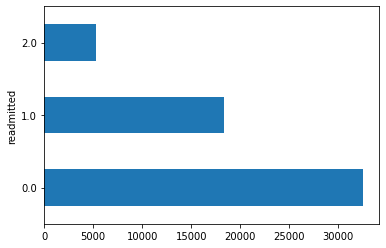

In [31]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

readmitted
0.0    14638
1.0     8238
2.0     2417
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


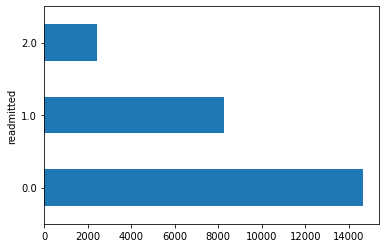

In [32]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

readmitted
0.0    7114
1.0    4042
2.0    1180
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


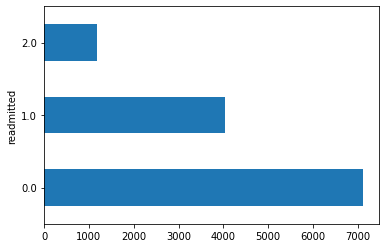

In [33]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female             29583
Male               26548
Unknown/Invalid        2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


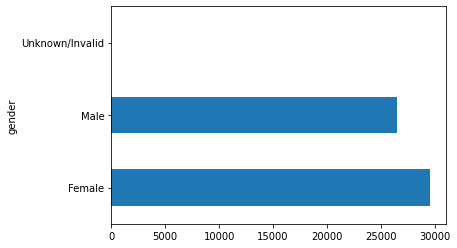

In [34]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female             13305
Male               11987
Unknown/Invalid        1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


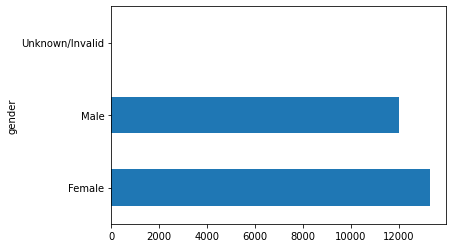

In [35]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    6452
Male      5884
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


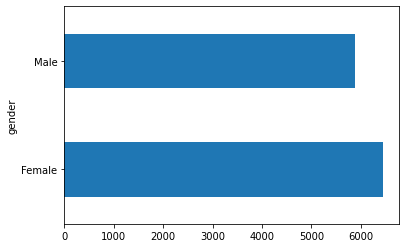

In [36]:
# Test partition
show_group_stats_viz(d_test, 'gender')

## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [22]:
# Convert dataset from Pandas dataframes to TF dataset 
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [23]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [24]:
vocab_file_list = build_vocab_files(d_train, student_categorical_col_list)

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [25]:
from student_utils import create_tf_categorical_feature_cols
tf_cat_col_list = create_tf_categorical_feature_cols(student_categorical_col_list)

In [26]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
EmbeddingColumn(categorical_column=VocabularyFileCategoricalColumn(key='admission_type_id', vocabulary_file='./diabetes_vocab/admission_type_id_vocab.txt', vocabulary_size=9, num_oov_buckets=0, dtype=tf.string, default_value=-1), dimension=8, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f2636770550>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)
tf.Tensor(
[[-0.21232751  0.17001544  0.25281566 ...  0.25964373 -0.05514732
   0.518121  ]
 [-0.21232751  0.17001544  0.25281566 ...  0.25964373 -0.05514732
   0.518121  ]
 [ 0.31094182  0.2082002  -0.32119513 ...  0.22439517  0.3729011
  -0.00137923]
 ...
 [ 0.05983278 -0.2779688  -0.2781204  ... -0.27015465  0.19019501
  -0.14754133]
 [ 0.31094182  0.2082002  -0.32119513 ...  0.22439517  0.3729011
  -0.00137923]
 [-0.21232751  0.17001544  0.25281566 ...  0.25964373 -0.05514732
   0.518121  ]], shape=(128,

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [27]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [28]:
def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [29]:
tf_cont_col_list = create_tf_numerical_feature_cols(student_numerical_col_list, d_train)

In [30]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_procedures', shape=(1,), default_value=(0,), dtype=tf.float32, normalizer_fn=<function create_tf_numeric_feature.<locals>.<lambda> at 0x7f26366c1ef0>)

tf.Tensor(
[[-1.]
 [ 0.]
 [-1.]
 [-1.]
 [ 0.]
 [-1.]
 [ 3.]
 [ 0.]
 [-1.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 4.]
 [ 1.]
 [ 0.]
 [-1.]
 [ 0.]
 [-1.]
 [-1.]
 [ 0.]
 [ 4.]
 [ 5.]
 [ 1.]
 [-1.]
 [ 5.]
 [ 1.]
 [-1.]
 [ 4.]
 [-1.]
 [ 4.]
 [ 2.]
 [ 0.]
 [ 5.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 4.]
 [ 2.]
 [-1.]
 [-1.]
 [ 5.]
 [ 2.]
 [ 1.]
 [-1.]
 [-1.]
 [ 5.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 3.]
 [ 0.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 2.]
 [-1.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 5.]
 [-1.]
 [ 1.]
 [ 3.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 5.]
 [ 2.]
 [ 0.]
 [ 0.]
 [ 5.]
 [ 0.]
 [-1.]
 [ 2.]
 [-1.]
 [ 2.]
 [ 0.]
 [-1.]
 [ 3.]
 [-1.]
 [ 5.]
 [ 0.]
 [ 3.]
 [-1.]
 [-1.]
 [ 4.]
 [-1.]
 [ 2.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 5.]
 [-1.]
 [-1.]
 [ 2.]
 [ 2.]
 [-1.]
 [-1.]
 [ 4.]
 [-1

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [31]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [32]:
def build_sequential_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
        tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),
        tfp.layers.DistributionLambda(
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                             scale=1e-3 + tf.math.softplus(0.01 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_diabetes_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_sequential_model(feature_layer)
    model.compile(optimizer='rmsprop', loss=loss_metric, metrics=[loss_metric])#'adam'
    early_stop = tf.keras.callbacks.EarlyStopping(monitor=loss_metric, patience=3)     
    history = model.fit(train_ds, validation_data=val_ds,
                        callbacks=[early_stop],
                        epochs=epochs)
    return model, history 

In [58]:
diabetes_model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=20)

Epoch 1/20
Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


Consider rewriting this model with the Functional API.


198/198 [==============================] - ETA: 0s - loss: 28.1364 - mse: 28.0765WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'patient_nbr': <tf.Tensor 'ExpandDims_34:0' shape=(None, 1) dtype=int64>, 'admission_type_id': <tf.Tensor 'ExpandDims_23:0' shape=(None, 1) dtype=string>, 'discharge_disposition_id': <tf.Tensor 'ExpandDims_26:0' shape=(None, 1) dtype=string>, 'admission_source_id': <tf.Tensor 'ExpandDims_22:0' shape=(None, 1) dtype=string>, 'medical_specialty': <tf.Tensor 'ExpandDims_29:0' shape=(None, 1) dtype=string>, 'primary_diagnosis_code': <tf.Tensor 'ExpandDims_35:0' shape=(None, 1) dtype=string>, 'other_diagnosis_codes': <tf.Tensor 'ExpandDims_33:0' shape=(None, 1) dtype=string>, 'max_glu_serum': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=string>, 'A1Cresult': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=string>, 'change': <tf.Tensor 'ExpandDims_25:0' shape=(None, 1) dtype=strin

Consider rewriting this model with the Functional API.


198/198 [==============================] - 10s 38ms/step - loss: 28.1314 - mse: 28.0712 - val_loss: 23.9358 - val_mse: 23.6916
Epoch 2/20
198/198 [==============================] - 7s 33ms/step - loss: 23.9582 - mse: 23.6935 - val_loss: 18.7713 - val_mse: 18.0974
Epoch 3/20
198/198 [==============================] - 7s 32ms/step - loss: 16.0416 - mse: 15.5653 - val_loss: 15.0774 - val_mse: 14.3462
Epoch 4/20
198/198 [==============================] - 7s 33ms/step - loss: 12.9421 - mse: 12.0744 - val_loss: 13.7342 - val_mse: 12.7338
Epoch 5/20
198/198 [==============================] - 7s 33ms/step - loss: 10.6073 - mse: 9.7598 - val_loss: 12.1565 - val_mse: 11.2090
Epoch 6/20
198/198 [==============================] - 7s 33ms/step - loss: 10.1878 - mse: 9.1139 - val_loss: 12.5082 - val_mse: 11.5522
Epoch 7/20
198/198 [==============================] - 7s 33ms/step - loss: 10.3321 - mse: 9.2843 - val_loss: 11.8083 - val_mse: 10.8437
Epoch 8/20
198/198 [==============================] - 

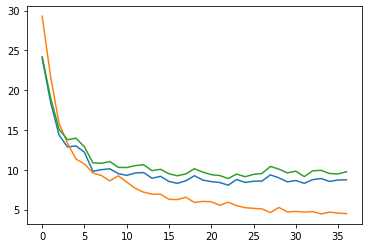

In [57]:
plt.plot(history.history['val_mse'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [35]:
feature_list = student_categorical_col_list + student_numerical_col_list
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = diabetes_model(diabetes_x_tst)
preds = diabetes_model.predict(diabetes_test_ds)

20       3
23       1
25       1
28       1
        ..
56119    3
56122    1
56123    1
56127    1
56132    1
Name: admission_type_id, Length: 12398, dtype: object, 'discharge_disposition_id': 16        6
20        1
23        1
25        2
28        1
         ..
56119     1
56122    22
56123     4
56127     1
56132     1
Name: discharge_disposition_id, Length: 12398, dtype: object, 'admission_source_id': 16       2
20       2
23       1
25       7
28       7
        ..
56119    1
56122    7
56123    7
56127    7
56132    7
Name: admission_source_id, Length: 12398, dtype: object, 'medical_specialty': 16                            ?
20                            ?
23              Surgery-General
25                   Cardiology
28       Family/GeneralPractice
                  ...          
56119                         ?
56122          InternalMedicine
56123                         ?
56127                         ?
56132                         ?
Name: medical_specialty, Length: 12398,

In [36]:
from student_utils import get_mean_std_from_preds
m, s = get_mean_std_from_preds(diabetes_yhat)

## Show Prediction Output 

In [37]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [38]:
prob_output_df.head()

,pred,actual_value,pred_mean,pred_std
0,1.695910,6.0,3.351597,0.688867
1,4.969543,3.0,4.892341,0.690202
2,1.384634,2.0,3.151203,0.689522
3,0.989240,5.0,2.992799,0.691527
4,5.146373,6.0,1.863692,0.689326


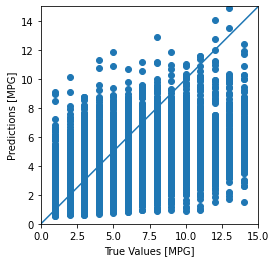

In [49]:
a = plt.axes(aspect='equal')
plt.scatter(d_test['time_in_hospital'].values, m.numpy().flatten())
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [39]:
from student_utils import get_student_binary_prediction
student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [40]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

/home/francois/anaconda3/envs/ehr/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/francois/anaconda3/envs/ehr/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/francois/anaconda3/envs/ehr/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is tryin

In [41]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']].head()

,patient_nbr,gender,race,time_in_hospital,score,label_value
16,69422211,Male,?,6.0,0.0,1
20,62718876,Female,AfricanAmerican,3.0,0.0,0
23,115196778,Female,Caucasian,2.0,0.0,0
25,18196434,Female,Caucasian,5.0,1.0,1
28,80845353,Female,Caucasian,6.0,0.0,1


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [118]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, brier_score_loss
y_true = df['label_value'].values 
y_pred = df['score'].values
accuracy_score(y_true, y_pred)
print(classification_report(y_true, y_pred))
roc_auc_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.56      0.83      0.67      1551
           1       0.44      0.18      0.25      1205

    accuracy                           0.54      2756
   macro avg       0.50      0.50      0.46      2756
weighted avg       0.51      0.54      0.49      2756



0.5023082417714713

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, roc_auc_score, brier_score_loss,\
roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve

df = pred_test_df.dropna(axis=0)[['patient_nbr', 'time_in_hospital', 'score', 'label_value']]
y_true = df['label_value'].values 
y_pred = df['score'].values
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
spe = tn/(tn+fp)*100
recall = tp/(tp+fn)*100
precision = tp/(tp+fp)*100
acc = (spe+recall)/2
f1 = 2*tp/(2*tp+fn+fp)
auc = roc_auc_score(y_true, y_pred)
bs = brier_score_loss(y_true, y_pred)

# AUC, F1, precision and recall
# Summary
print('precision:%.3f\nrecall:%.3f\nspecificity:%.3f\naccuracy:%.3f\nF1:%.3f\nauc:%.3f\nBrier score:%.3f\n'%(precision, recall, spe, acc, f1, auc,bs))
print(classification_report(y_true, y_pred))

precision:38.105
recall:16.018
specificity:81.863
accuracy:48.940
F1:0.226
auc:0.489
Brier score:0.452

              precision    recall  f1-score   support

           0       0.58      0.82      0.68      1621
           1       0.38      0.16      0.23      1130

    accuracy                           0.55      2751
   macro avg       0.48      0.49      0.45      2751
weighted avg       0.50      0.55      0.49      2751



# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [44]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/home/francois/anaconda3/envs/ehr/lib/python3.7/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [45]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'}, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

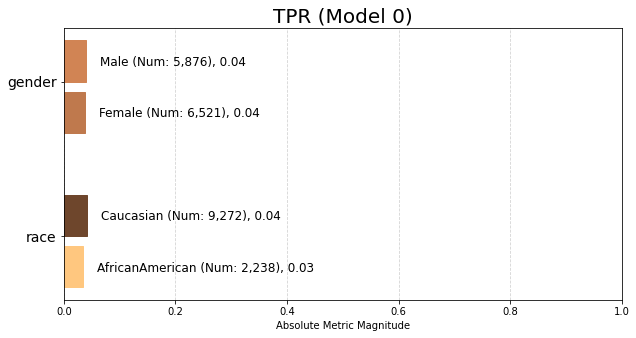

In [46]:
aqp.plot_group_metric(clean_xtab, 'tpr', min_group_size=0.05)

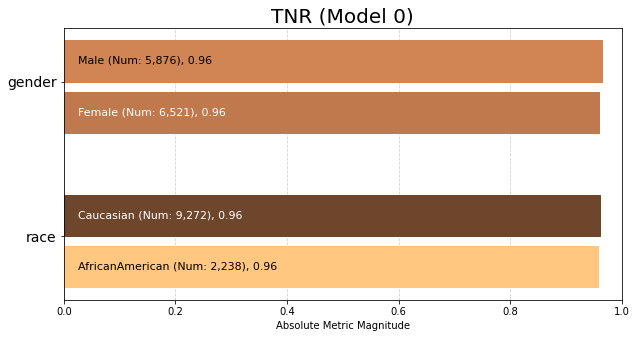

In [47]:
aqp.plot_group_metric(clean_xtab, 'tnr', min_group_size=0.05)

<AxesSubplot:title={'center':'TNR (Model 0)'}, xlabel='Absolute Metric Magnitude'>

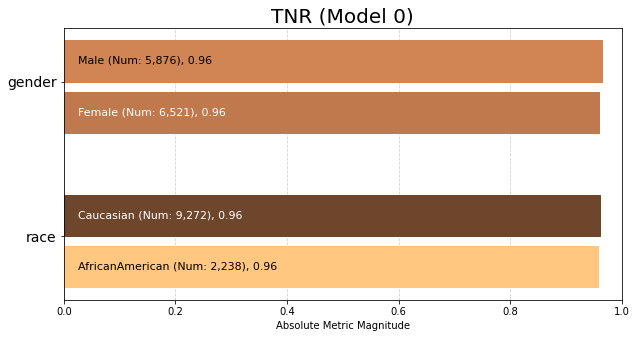

In [55]:
aqp.plot_group_metric(clean_xtab, 'tnr', min_group_size=0.05)

In [ ]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?
#There is no signifiant bias for either race or gender

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

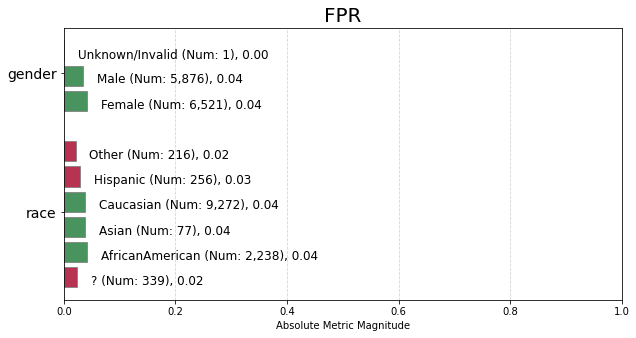

In [53]:
# Reference group fairness plot
aqp.plot_fairness_group(fdf, group_metric='fpr', title=True)